# Choice of data and its source
Binance is one of the largest worldwide cryptoexchanges. It also has a relatively simple API, so downloading data won't take too much time.

We've chosen to download data on 15-minutes candles, as it it will be more complicated task compared to predicting 5-minute candles and easier than predicting 30-minutes (etc) candles.

We've chosen BTC, as this is the main cryptocurrency with has the largest impact on prices of other cryptocurencies.

#### Authors:
 - Denis Shilov
 - Andrey Ermakov
 - Vasily Kireenko
 - Grigory Buzilov

![Picture title](image-20210129-145010.png)

# Imports and constants
What we use here is:

- os package to communicate with the operating system

- binance API to get historical data on BTC 

- pickle to save and load up data

- sktime to predict our time series data

- numpy to compute some stuff

- pmdarima to check for stationarity

- lightgbm is one of the most famous boostings

- xgboost is another famous boosting


In [ ]:
import os
import pickle
from binance.client import Client
import numpy as np
import pandas as pd
from pmdarima.arima import ADFTest
from sklearn.pipeline import Pipeline
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    ReducedRegressionForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sktime.forecasting.fbprophet import Prophet
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.utils.plotting import plot_series

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
API_KEY = os.environ["API_KEY"]
API_SECRET = os.environ["SECRET_KEY"]

PAIR = "BTCUSDT"
START = "4 weeks ago UTC"
CANDLES_TYPE = Client.KLINE_INTERVAL_15MINUTE

# Loading data

We will save data for later usage just not to waste time loading this each time we start up the notebook 

In [ ]:
CACHED_DATA = "cache.pkl"

In [ ]:
def save(klines):
    with open(CACHED_DATA, 'wb+') as outfile:
        pickle.dump(klines, outfile)

def load_new_data():
    client = Client(API_KEY, API_SECRET)
    klines = client.get_historical_klines(
        PAIR, 
        CANDLES_TYPE, 
        START
    )

    save(klines)
    return klines

def load_cached_data():
    with open(CACHED_DATA, 'rb') as outfile:
        return pickle.load(outfile) 

def load_data():
    if os.path.exists(CACHED_DATA):
        return load_cached_data()

    else:
        return load_new_data()

# Inspecting the data

Huh, we are finally here! Now let's play with the data :-)

In [ ]:
klines = load_data()

Let's see what it looks like

In [ ]:
klines[0]

[1609398000000,
 '28859.02000000',
 '29230.00000000',
 '28859.02000000',
 '29160.17000000',
 '1039.84389600',
 1609398899999,
 '30256648.14109882',
 20186,
 '684.68057800',
 '19926385.16293247',
 '0']

According to binance API, it corresponds to:




![Picture title](image-20210127-145619.png)

#### We should ignore:

1. Close time, as we already know that it is a 15-minute candle. 

2. API tells us to ignore last element

3. "Quote asset volume", as it duplicates the meaning of the "Volume" 

4. "Taker buy quote asset volume", as it duplicates the meaning of the "Taker buy base asset volume"

# Parsing the data 

Our goal is to predict *something*. But we have here 4 prices, not 1 price! 

So we will get a weighted average of a candle, which we will try to predict. 

High and Low prices are not as much interesting as Open and Close one, as they are like outliers.

In [ ]:
def get_weighted_average(candle):
    open_price = float(candle[1])
    high_price = float(candle[2])
    low_price = float(candle[3])
    close_price = float(candle[4])

    weighted = open_price + (high_price + low_price) / 2 + close_price
    return weighted / 3

#### What can we use to train our models?

1. Weighted average

2. Volume

3. Number of trades

4. Taker buy base asset volume

What we will try to perform is called "Time series forecasting", as we will forecast several properties of candles in the future

In [ ]:
WA = "WEIGHTED AVERAGE"
VOL = "VOLUME"
TN = "TRADES NUMBER"
TAKER = "TAKER"
TIME = "TIME"

COLUMNS = [WA, VOL, TN, TAKER]

In [ ]:
def reparse_candle(candle):
    weighted_average = get_weighted_average(candle)

    return [
        weighted_average,
        float(candle[5]),
        float(candle[8]),
        float(candle[9]),
        int(candle[0])
    ]
       
parsed_klines = pd.DataFrame(
    list(map(reparse_candle, klines)), 
    columns=[WA, VOL, TN, TAKER, TIME]
)    

Let's see how the last thousand of entries looks like

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='WEIGHTED AVERAGE'>)

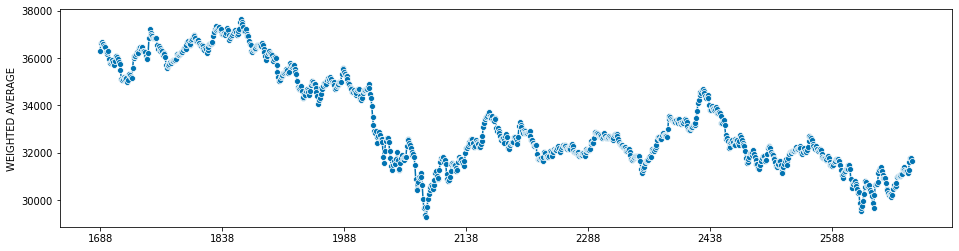

In [ ]:
plot_series(parsed_klines[WA][-1000:-1])

Now we need to test our data for stationarity. 

A stationary process is such a process in which the probability distribution does not depend on time. 

And stationary things are more suitable for being predicted!

White noise is the simplest example of a stationary process.

REMINDER: A white noise process is one with a mean zero and no correlation between its values at different times.

In [ ]:
def check_stationarity(klines):
    adf_test = ADFTest(alpha=0.05)
    
    print(adf_test.should_diff(klines[WA]))
    print(adf_test.should_diff(klines[VOL]))
    print(adf_test.should_diff(klines[TN]))
    print(adf_test.should_diff(klines[TAKER]))

In [ ]:
check_stationarity(parsed_klines)

(0.4785548299531216, True)
(0.01, False)
(0.01, False)
(0.01, False)


As we can see, our time series is non-stationary. In order to predict it successfully, we need to make a stationary thing out of it.

How to do it? There're several options:

- Differencing. For example, you need to compute the differences between consecutive observations.

- Subtraction of rolling mean. A rolling mean is the mean of the previous x number of observations in the series, where the time between each observation is consistent.

- De-trending is fundamental. This includes regressing against covariates other than time.

- Seasonal adjustment is a version of taking differences but could be construed as a separate technique.

- Transformation of the data implicitly converts a difference operator into something else; e.g., differences of the logarithms are actually ratios.

There are enormous number of techniques for making a non-stationary time series, stationary. 

We have decided to start with differencing:

In [ ]:
PERIOD = 1

parsed_klines[WA] = parsed_klines[WA].diff(periods=PERIOD)
parsed_klines = parsed_klines.iloc[PERIOD:]

In [ ]:
parsed_klines

,WEIGHTED AVERAGE,VOLUME,TRADES NUMBER,TAKER,TIME
1,151.320000,1036.174527,20052.0,585.993770,1609398900000
2,-8.333333,683.328350,15092.0,375.363497,1609399800000
3,-12.491667,432.736200,11169.0,174.837365,1609400700000
4,-71.673333,1072.129851,22176.0,462.212343,1609401600000
5,-142.458333,1064.822347,21930.0,410.520227,1609402500000
...,...,...,...,...,...
2683,320.118333,1505.062375,24821.0,837.093903,1611812700000
2684,198.230000,1537.387608,25651.0,838.929172,1611813600000
2685,-16.536667,691.137950,16143.0,359.432165,1611814500000
2686,-111.601667,652.178982,16965.0,368.539437,1611815400000


In [ ]:
check_stationarity(parsed_klines)

(0.01, False)
(0.01, False)
(0.01, False)
(0.01, False)


You see? Now we have all time series as stationary ones!

The same thing as above (I mean differncing) could be achieved by using models with "I" in their name, which typically means Integrated. 

For example, one of such models is ARIMA, which we will try to use in the next chapter.

# Trying ARIMA

To begin with, we must state the rules which we use to measure the performance of the model.

There are many different approaches to evaluate that, and they are applied to different types of models:

- MSE 

- AIC, special criterion used to penalize models for their overcomplicatedness

- sMAPE, which gives us an error in percents

- ...

Our dataset consists of 4 months of candles from Binance.

We will test the performance of the model on the last month of the dataset, and we will train on the other 3 months.

Then we will evaluate the model based on sMAPE to get the evaluation of our error in percent: the lower the error, the better our model is.

In [ ]:
TRAIN_RATIO = 0.75

Here we're splitting our dataset on test and train parts needed to evaluate model performance:

In [ ]:
size = int(len(parsed_klines) * TRAIN_RATIO)
train, test = temporal_train_test_split(parsed_klines, test_size=size)

## Training one model

Now we're ready to model our time series. 

Now we'll try AutoARIMA: it chooses the best suitable ARIMA model, automatically finding optimal hyperparameters. 

By default, it compares the models based on AIC, which is good: AIC takes into account both the complexity of the model and its accuracy.

The parameters in a seasonal ARIMA, $ARIMA(p,d,q)(P,D,Q,m)$ are:

- p - number of estimated coefficients in non-seasonal AR part

- d - number of transitions to non-seasonal difference

- q - number of estimated coefficients in non-seasonal MA part

- P - number of estimated coefficients in seasonal AR

- D - number of transitions to seasonal difference

- Q - number of estimated coefficients in seasonal MA part

- m - seasonality period

So ARIMA takes form of:

$(1-L)^{d}X_{t}=c+(\sum\limits _{i=1}^{p}a_{i}L^{i})(1-L)^{d}X_{t}+(1+\sum\limits_{j=1}^{q}b_{j}L^{j})\varepsilon _{t}$

Where $\varepsilon _{t}$ - stationary process.

$c,a_{i},b_{j}$- parameters of the model.

As we are working with AutoARIMA, by default it starts from:

- p = 2

- q = 2

- P = 1

- Q = 1

And stops when:

- p = 5 

- d = 2 

- q = 5 

- P = 2

- D = 1 

- Q = 2

Note: At the start d and D are automatically selected based on the results of the seasonal_test

Here is some code to get the loss of the model using sMAPE:

In [ ]:
def get_loss(forecaster, column):
    if isinstance(column, str):
        fh = ForecastingHorizon(test[column].index, is_relative=False)
        pred = forecaster.predict(fh)
        loss = smape_loss(test[column], pred)

        return loss

    else:
        fh = ForecastingHorizon(column.index, is_relative=False)
        pred = forecaster.predict(fh)
        loss = smape_loss(column, pred)

        return loss

An utility function to output our losses for each of the time series we use:

In [ ]:
def output_losses(losses):
    for i in range(len(COLUMNS)):
        loss = losses[i]

        if not isinstance(loss, float):
           loss = loss[0]

        print(COLUMNS[i], "has loss", loss)

And that is the code for training ARIMA model for each of time series individually:

In [ ]:
losses = []

for column in COLUMNS:
    forecaster = AutoARIMA(
        sp=12, 
        stationary=True,
        error_action="ignore"
    )

    forecaster.fit(train[column])

    loss = get_loss(forecaster, column)
    losses.append(loss)

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
output_losses(losses)

WEIGHTED AVERAGE has loss 1.7183597369641563
VOLUME has loss 0.47419604212675237
TRADES NUMBER has loss 0.32968231106878776
TAKER has loss 0.48574242509534016


We can see that the easiest task for ARIMA is to predict TRADES NUMBER, and the most complicated part is the price.

That's okay with our common sense: if it would be easy to predict the prices, then we all would be billionaires.

## Training using GridSearch

To find optimal parameters of our model, we will start a GridSearch. 

It is such thing which finds out which combination of model parameters results in the best performance.

In [ ]:
grids_arima = []
losses = []

cv = SlidingWindowSplitter(initial_window=int(len(train) * 0.5))
param_grid = {
    "sp": [x for x in range(1, 13, 2)]
}

for column in COLUMNS:
    forecaster = AutoARIMA(
        stationary=True,
        error_action="ignore"
    )

    gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)
    gscv.fit(train[column])
    
    loss = get_loss(gscv, column)
    losses.append(loss)

    grids_arima.append(gscv)

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

## GridSearch results

We can see which parameters were the best for each of the time series, and the corresponding loss in sMAPE:

In [ ]:
def output(grids, losses):
    for index in range(len(grids)):
        gscv = grids[index]
        loss = losses[index]
        print(gscv.best_params_, loss)

In [ ]:
output(grids_arima, losses)

{'sp': 5} 1.7183597369641563
{'sp': 9} 0.4819413229155683
{'sp': 9} 0.329005030368896
{'sp': 9} 0.48985999621001775


# Trying ETS 

Another model we would like to try is ETS, which stays for a trend component (T), a seasonal component (S), and an error term (E).

As there is an AutoARIMA in sktime, then AutoETS is also presented here. 

Our hands are clear: AutoETS will provide us with the best model by itself, choosing that with AIC by default.

$ETS(A, A_d, N)$:

$A: y_{T+1} = l_t + b_t + \varepsilon_{T+1}$

$A_d: y_t = l_t + \phi_h b_t, \phi_h = \sum\limits_{i=1}^{h} \phi^i$

$N: \hat y_{T+h} = l_t$

## Training one model

As we already know optimal sp from the previous GridSearch result of ARIMA, and we have the same dataset, then we'll reuse it:

In [ ]:
def get_sp(column):
    index = COLUMNS.index(column)
    return grids_arima[index].best_params_["sp"]

In [ ]:
losses = []

for column in COLUMNS:
    sp = get_sp(column)

    forecaster = AutoETS(
        sp=sp,
        error_action="ignore"
    )

    forecaster.fit(train[column])

    loss = get_loss(forecaster, column)
    losses.append(loss)

In [ ]:
output_losses(losses)

WEIGHTED AVERAGE has loss 1.6968994425702442
VOLUME has loss 0.42977915178565806
TRADES NUMBER has loss 0.32390295455733603
TAKER has loss 0.4367946089245255


## Training using GridSearch

In [ ]:
grids_ets = []
losses = []

cv = SlidingWindowSplitter(initial_window=int(len(train) * 0.5))
param_grid = {
    "initialization_method": ["estimated", "heuristic"],
    "error": ["add", "mul"]
}

for column in COLUMNS:
    sp = get_sp(column)

    forecaster = AutoETS(
        sp=sp,
        error_action="ignore"
    )

    gscv = ForecastingGridSearchCV(
        forecaster, 
        cv=cv, 
        param_grid=param_grid
    )

    gscv.fit(train[column])
    loss = get_loss(gscv, column)
    losses.append(loss)

    grids_ets.append(gscv)

/usr/local/lib/python3.7/site-packages/sktime/forecasting/model_selection/_tune.py:144: FitFailedWarning: forecaster fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: endog must be strictly positive when usingmultiplicative error, trend or seasonal components.

  FitFailedWarning,


## GridSearch results

In [ ]:
output(grids_ets, losses)

{'error': 'add', 'initialization_method': 'estimated'} 1.6968994425702442
{'error': 'add', 'initialization_method': 'estimated'} 0.42977915178565806
{'error': 'add', 'initialization_method': 'estimated'} 0.32390295455733603
{'error': 'add', 'initialization_method': 'heuristic'} 0.4367946080104173


As we can see from the results, sMAPE of ETS is less than ARIMA. So ETS gives more accuracy on this dataset than ARIMA.

# Trying Prophet

Prophet is a model developed by Facebook. In fact, it is an additive regression model consisting of the following components:

$y(t) = g(t) + s(t) + h(t) + \epsilon_{t}$

The seasonal s(t) component is responsible for the simulation of periodic changes associated with weekly and year-by-year seasonality.

$g(t) = \dfrac{C}{1+exp(-k(t-b))}$

The component h(t) is responsible for the abnormal days specified by the user, including irregular ones, such as, for example, Black Fridays.


In [ ]:
losses = []

for column in COLUMNS:
    forecaster = Prophet(
        seasonality_mode="multiplicative",
        yearly_seasonality="auto",
        weekly_seasonality="auto",
        daily_seasonality="auto",
        n_changepoints=int(len(train) / 12)
    )

    date_train = train[[column, TIME]].copy()
    date_train[TIME] = pd.to_datetime(date_train[TIME])
    date_train = date_train.set_index(TIME)

    date_test = test[[column, TIME]].copy()
    date_test[TIME] = pd.to_datetime(date_test[TIME])
    date_test = date_test.set_index(TIME)

    forecaster.fit(date_train[column])

    loss = get_loss(forecaster, date_test[column])
    losses.append(loss)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_s

In [ ]:
output_losses(losses)

WEIGHTED AVERAGE has loss 1.5003633751855936
VOLUME has loss 0.49953051077977845
TRADES NUMBER has loss 0.31980267714585675
TAKER has loss 0.43538197696602343


We can see that Prophet gives way more better accuracy than ETS or ARIMA.

Mark Zuckerberg, congratulations, you spend your money correctly.

# Trying some gradient boosting

## Training one model

Let's try to use XGBoost, one of the most famous boosting things.

$h(x) = \sum\limits_{i=1}^nb_i\cdot a_i$  

Where $ x \in X, b_i \in R$

it also uses:

$err(h) = \sum\limits_{j=1}^N L(\sum\limits_{i=1}^{T-1}a_ib_i(x_j) + b_Ta_T(x_j)) + \sum\limits_{i=1}^T \omega(a_i)$

$\omega(a) = \gamma Z + 0.5*\sum\limits_{i=1}^{Z}w_i^2$

w - leaves values, Z — number of leaves.

In [ ]:
losses = []

for column in COLUMNS:
    cat = XGBRegressor()

    forecaster = ReducedRegressionForecaster(
        regressor=cat, 
        window_length=4,
        strategy="recursive"
    )

    forecaster.fit(train[column])

    loss = get_loss(forecaster, column)
    losses.append(loss)

In [ ]:
output_losses(losses)

WEIGHTED AVERAGE has loss 1.5450233639161863
VOLUME has loss 0.6486969933868533
TRADES NUMBER has loss 0.38743751681119615
TAKER has loss 0.5828923829341264


## Training using GridSearch

In [ ]:
xgb = XGBRegressor()
lgb = LGBMRegressor()

In [ ]:
losses = []
grids_boostings = []

cv = SlidingWindowSplitter(initial_window=int(len(train) * 0.5))
param_grid = {
    "window_length": [x for x in range(4, 30, 2)],
    "regressor": [xgb, lgb]
}

for column in COLUMNS:
    forecaster = ReducedRegressionForecaster(regressor=xgb)
    gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)
    gscv.fit(train[column])

    loss = get_loss(gscv, column)
    losses.append(loss)

    grids_boostings.append(gscv)

## GridSearch results

In [ ]:
output(grids_boostings, losses)

{'regressor': LGBMRegressor(), 'window_length': 8} 1.5819748662194233
{'regressor': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), 'window_length': 24} 1.2932167740884875
{'regressor': LGBMRegressor(), 'window_length': 24} 0.39034882740601673
{'regressor': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, i

{'regressor': LGBMRegressor(), 'window_length': 8} 1.5819748662194233
{'regressor': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), 'window_length': 24} 1.2932167740884875
{'regressor': LGBMRegressor(), 'window_length': 24} 0.39034882740601673
{'regressor': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, i

We can see an interesting detail. According to the results of GridSearch, window length equal to 8 gives the most performance forecasting price.

And for the other characteristics (volume, trades number, etc) long window is needed.

# Stacking different models together

Stack is a thing which takes the outputs of other models and somehow sums them up using other model.

As we know now the optimal parameters of each model for each tipe of time series we have, we can reuse them!

In [ ]:
losses = []

for column in COLUMNS:
    index = COLUMNS.index(column)

    forecaster = EnsembleForecaster([
        (
            "arima", 
            AutoARIMA(
                sp=grids_arima[index].best_params_["sp"], 
                stationary=True
            )
        ),
        (
            "ets",
            AutoETS(
                error=grids_ets[index].best_params_["error"], 
                initialization_method=grids_ets[index].best_params_["initialization_method"],
                sp=grids_arima[index].best_params_["sp"]
            ),
        )
    ])

    forecaster.fit(train[column])

    loss = get_loss(forecaster, column)
    losses.append(losses)

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
output_losses(losses)

WEIGHTED AVERAGE has loss 1.7183613294373088
VOLUME has loss 0.47419604212675237
TRADES NUMBER has loss 0.32968231106878776
TAKER has loss 0.48574242509534016


WEIGHTED AVERAGE has loss [[...], [...], [...], [...]]
VOLUME has loss [[...], [...], [...], [...]]
TRADES NUMBER has loss [[...], [...], [...], [...]]
TAKER has loss [[...], [...], [...], [...]]


We see that in some cases the ensemble of the regressors performs better than each of its regressor as a single one, and in some cases they are not.

That fact is illustrated with a meme. Apes together strong, but they're still apes.

![Picture title](image-20210128-145009.png)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b73e4632-40f9-439a-a4a0-a958c5c89d05' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>